# Topic Modeling with Gensim

In [1]:
# Example 1: Load libraries
import warnings
import pandas as pd

# import packages for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

from gensim.corpora import Dictionary
from gensim.models import ldamodel
import numpy
%matplotlib inline

# To ignore all warnings that arise here to enhance clarity
warnings.filterwarnings(action='ignore', category=UserWarning)

### Example 2: Set up corpus now. In the toy corpus presented, there are 6 documents.

In [2]:
texts = ["Human machine interface enterprise resource planning system quality processing management",
         "management processing quality enterprise resource planning systems is user management",
         "human engineering testing of enterprise resource planning system processing quality management",
         "food desert poor staff good service cheap price bad location restaurant",
         "good service poor food resturant staff bad service price desert good location",
         "restaurant poor service bad food desert staff bad service high price good location"
         ]

In [3]:
# Example 3: Clean data 
# You will need to review previous modules (e.g., sentiment analysis, descriptive analytics) for text cleaning and transforming

# Example 3a: Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-z,A-Z]+", " ",text) for text in texts]
# Example 3b: tokenize & lowercase
texts = [[word for word in text.lower().split() ] for text in documents]
# Example 3c: stemming words: having --> have; friends --> friend
lmtzr = WordNetLemmatizer()
texts = [[lmtzr.lemmatize(word) for word in text ] for text in texts]
# Example 3d: remove common words
stoplist = stopwords.words('english')
texts = [[word for word in text if word not in stoplist] for text in texts]
# Example 3e: remove short words
texts =[[word for word in tokens if len(word) >=3] for tokens in texts]

In [4]:
# Example 4: Text processing required for topic modeling with Gensim

# Example 4a: Create a dictionary representation of the documents.
dictionary = Dictionary(texts)

# Example 4b: convert words to vetors or integers
corpus = [dictionary.doc2bow(text) for text in texts]

## Example 5: Determine Optimal k value (e.g. Number of Topics)

Vowpal Wabbit (also known as "VW") is an open-source fast out-of-core machine learning system library and program developed originally at Yahoo! Research, and currently at Microsoft Research. It was started and is led by John Langford. Vowpal Wabbit is notable as an efficient scalable implementation of online machine learning with support for a number of machine learning reductions, importance weighting, and a selection of different loss functions and optimization algorithms. 

LDAMALLET is based on a Java-based package for statistical natural language processing, document classification, clustering, topic modeling, information extraction, and other machine learning applications to text. It is available in Python.

Coherence Model calculates topic coherence for topic models. This is the implementation of the four stage topic coherence pipeline from the paper Michael Roeder, Andreas Both and Alexander Hinneburg: “Exploring the space of topic coherence measures”. Typically, CoherenceModel used for evaluation of topic models.

The four stage pipeline is basically:

        Segmentation

        Probability Estimation

        Confirmation Measure

        Aggregation

Implementation of this pipeline allows for the user to in essence “make” a coherence measure of his/her choice by choosing a method in each of the pipelines.

In [5]:
# Example 5a: Get Models for LDA
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

# Example 5b: setting random seed to get the same results each time for different topic sizes. 
numpy.random.seed(1)
for k in range(2, 10):
    goodLdaModel = ldamodel.LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=k, passes=50)
    goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus,
                            dictionary=dictionary, coherence='u_mass')
    print(goodcm.get_coherence())

-13.81987168167417
-14.368954324963461
-14.201616707368425
-14.288189745898999
-15.078166713192537
-14.430611226211456
-14.151415671346621
-14.278835278051272


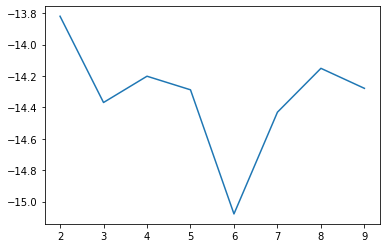

In [6]:
# Example 5c: Plot Output
import matplotlib.pyplot as plt
%matplotlib inline

numpy.random.seed(1)  # setting random seed to get the same results each time.
k_range = range(2, 10)
scores = []
for k in k_range:
    goodLdaModel = ldamodel.LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=k, passes=50)
    goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus,
                            dictionary=dictionary, coherence='u_mass')
    scores.append(goodcm.get_coherence())

plt.figure()
plt.plot(k_range, scores)

# Example 6: LDA Model Building

In [7]:
# Example 6a: build a LDA topic model with 2 topics
numpy.random.seed(1) # setting random seed to get the same results each time. 
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, passes=20)

In [8]:
# Example 6b: print term-topic distribution
model.show_topics()


[(0,
  '0.112*"service" + 0.092*"good" + 0.092*"bad" + 0.071*"food" + 0.071*"location" + 0.071*"price" + 0.071*"staff" + 0.071*"desert" + 0.071*"poor" + 0.051*"restaurant"'),
 (1,
  '0.107*"management" + 0.083*"quality" + 0.083*"planning" + 0.083*"system" + 0.083*"resource" + 0.083*"processing" + 0.083*"enterprise" + 0.059*"human" + 0.036*"testing" + 0.036*"engineering"')]

In [9]:
# Example 6c: print words without probability

for i in range(0, 2):
    topics = model.show_topic(i, 10)
    print(', '.join([str(word[0]) for word in topics]))

service, good, bad, food, location, price, staff, desert, poor, restaurant
management, quality, planning, system, resource, processing, enterprise, human, testing, engineering


In [10]:
# Example 6d: Assign topics to documenhts 
lda_corpus = model[corpus]

results = []
for i in lda_corpus:
    print(i)
    results.append(i)
print()

[(0, 0.04620811), (1, 0.95379186)]
[(0, 0.050679438), (1, 0.9493205)]
[(0, 0.04620771), (1, 0.9537923)]
[(0, 0.9575669), (1, 0.042433117)]
[(0, 0.9608999), (1, 0.039100103)]
[(0, 0.96367157), (1, 0.03632842)]



In [11]:
# Example 6e:  finding highest value from each row
toptopic = [max(collection, key=lambda x: x[1])[0] for collection in results]
toptopic[:10]

[1, 1, 1, 0, 0, 0]

And like we expected, the LDA model has given us near perfect results. 3 `restaurant` related and 3 `enterprise` related.

In [12]:
# Example 6f: Put into data frame
toptopic = pd.DataFrame(toptopic)
documents = pd.DataFrame(documents)
documents = documents.rename(columns={0: 'documents'})
summary = documents.join(toptopic)
summary

,documents,0
0,Human machine interface enterprise resource pl...,1
1,management processing quality enterprise resou...,1
2,human engineering testing of enterprise resour...,1
3,food desert poor staff good service cheap pric...,0
4,good service poor food resturant staff bad ser...,0
5,restaurant poor service bad food desert staff ...,0


This exercise has shown you how to perform topic modeling with Gensim. The results show two hiddent topics in the data. One is about **restaurant** and the other **enterprise**.

# Example 7 Show interactive Topic Map

In [13]:
import pyLDAvis.gensim

C:\Users\Vejendla\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [14]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

C:\Users\Vejendla\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.145201  0.0       1        1  55.341549
1     -0.145201  0.0       2        1  44.658451, topic_info=   Category      Freq        Term     Total  loglift  logprob
4   Default  3.000000  management  3.000000  26.0000  26.0000
22  Default  4.000000     service  4.000000  25.0000  25.0000
7   Default  2.000000     quality  2.000000  24.0000  24.0000
5   Default  2.000000    planning  2.000000  23.0000  23.0000
9   Default  2.000000      system  2.000000  22.0000  22.0000
..      ...       ...         ...       ...      ...      ...
18   Topic2  0.347285    location  2.914882  -1.3213  -4.4259
16   Topic2  0.347271        food  2.914884  -1.3214  -4.4259
13   Topic2  0.347217         bad  3.649007  -1.5461  -4.4261
17   Topic2  0.347211        good  3.649007  -1.5462  -4.4261
22   Topic2  0.347422     service  4.383114  -1.7288  -4.4255

[78 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
13        1  0.822141          bad
14        1  0.691251        cheap
15        1  1.029202       desert
11        2  0.712325  engineering
0         2  0.717825   enterprise
16        1  1.029201         food
17        1  0.822141         good
25        1  0.691245         high
1         2  0.954647        human
2         2  0.712320    interface
18        1  1.029201     location
3         2  0.712320      machine
4         2  0.862722   management
5         2  0.717827     planning
19        1  1.029202         poor
20        1  1.029201        price
6         2  0.717826   processing
7         2  0.717828      quality
8         2  0.717826     resource
21        1  0.917107   restaurant
24        1  0.691247    resturant
22        1  0.912593      service
23        1  1.029201        staff
9         2  0.717827       system
12        2  0.712325      testing
10        2  0.712311         user, R=26, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# Example 8: Show Term and Document Topics

We want to show off the new `get_term_topics` and `get_document_topics` functionalities, and a good way to do so is to play around with words which might have different meanings in different context.


### Example 8a: get_term_topics

The function `get_term_topics` returns the odds of that particular word belonging to a particular topic. 
A few examples:

In [15]:
model.get_term_topics('management')

[(1, 0.09655176)]

Makes sense, the value for it belonging to `topic_0` is a lot more.

In [16]:
model.get_term_topics('system')

[(1, 0.07255401)]

### Example 8b: get_document_topics (Predictive Analytics)

`get_document_topics` is an already existing gensim functionality which uses the `inference` function to get the sufficient statistics and figure out the topic distribution of the document.

The addition to this is the ability for us to now know the topic distribution for each word in the document. 
Let us test this with two different documents which have the word bank in it, one in the finance context and one in the river context.

The `get_document_topics` method returns (along with the standard document topic proprtion) the word_type followed by a list sorted with the most likely topic ids, when `per_word_topics` is set as true.

In [17]:
# Example 8c: Set up two new documents
bow_resturant = ['bad', 'food', 'location', 'food']
bow_enterprise = ['quality', 'system', 'resource']

In [18]:
# Example 8d: convert to bag of words format first
bow = model.id2word.doc2bow(bow_resturant)
print(bow)

[(13, 1), (16, 2), (18, 1)]


In [19]:
# Example 8e: Display new words and their topics
doc_topics, word_topics, phi_values = model.get_document_topics(
    bow, per_word_topics=True)

word_topics

[(13, [0]), (16, [0]), (18, [0])]

### Example 9: What does that output mean? It means that all three words are more likely to be in `topic_0` than `topic_1`.

In [20]:
doc_topics

[(0, 0.89849526), (1, 0.10150473)]

In [21]:
phi_values

[(13, [(0, 0.9984943)]), (16, [(0, 1.9959924)]), (18, [(0, 0.997996)])]

bow_resturant = ['bad','food','location'] is likely to be "topic_0" (restaurant)

Now that we know exactly what `get_document_topics` does, let us now do the same with our second document, `bow_finance`.

In [22]:
# Example 10: convert to bag of words format first
bow = model.id2word.doc2bow(bow_enterprise)
doc_topics, word_topics, phi_values = model.get_document_topics(
    bow, per_word_topics=True)
word_topics

[(7, [1]), (8, [1]), (9, [1])]

In [23]:
phi_values

[(7, [(1, 0.9980631)]), (8, [(1, 0.9980612)]), (9, [(1, 0.9980619)])]

In [24]:
doc_topics

[(0, 0.1264527), (1, 0.8735473)]

The new (or unlabeled) document "quality system resource" is classfied as topic_1

### Action 1 Required: Predicting the topic distribution of a new (or unlabled) document: Finish this section like those above.

In [39]:
# 2 New documents for your use (please create your own 2 or 3 topic document list)
unlabeled = ["poor service, looks bad restaurant management, menu is overpriced",
             "Good food, great drinks. If I could only eat at one place for the rest of my life I would pick Jp's Gastropub, absolutely electric atmosphere. 10/10 would recommend",
             "management of enterprise resource planning systems",
             "Enterprise resource planning is the integrated management of main business processes, often in real time and mediated by software and technology"]

In [40]:
# Action 1a Required: Remove useless numbers and alphanumerical words
unlabeled = [re.sub("[^a-z,A-Z]+", " ",text) for text in unlabeled]
# Action 1b Required: tokenize & lowercase
unlabeled = [[word for word in text.lower().split() ] for text in unlabeled]
# Action 1c Required: stemming words: having --> have; friends --> friend
lmtzr = WordNetLemmatizer()
unlabeled = [[lmtzr.lemmatize(word) for word in text ] for text in unlabeled]
# Action 1d Required: remove common words
stoplist = stopwords.words('english')
unlabeled = [[word for word in text if word not in stoplist] for text in unlabeled]
# Action 1e Required: remove short words
unlabeled = [[word for word in tokens if len(word) >=3] for tokens in unlabeled]

In [41]:
# Action 1f Required: Now your data is cleaned
unlabeled

[['poor',
  'service,',
  'look',
  'bad',
  'restaurant',
  'management,',
  'menu',
  'overpriced'],
 ['good',
  'food,',
  'great',
  'drink',
  'could',
  'eat',
  'one',
  'place',
  'rest',
  'life',
  'would',
  'pick',
  'gastropub,',
  'absolutely',
  'electric',
  'atmosphere',
  'would',
  'recommend'],
 ['management', 'enterprise', 'resource', 'planning', 'system'],
 ['enterprise',
  'resource',
  'planning',
  'integrated',
  'management',
  'main',
  'business',
  'processes,',
  'often',
  'real',
  'time',
  'mediated',
  'software',
  'technology']]

In [42]:
# Action 1g Required: review documents
for i in unlabeled:
    print(model.id2word.doc2bow(i))

[(13, 1), (19, 1), (21, 1)]
[(17, 1)]
[(0, 1), (4, 1), (5, 1), (8, 1), (9, 1)]
[(0, 1), (4, 1), (5, 1), (8, 1)]


In [50]:
# Action 1h Required: Get Topic for new documents 
for i in unlabeled:
    bow = model.id2word.doc2bow(i)
    doc_topics, word_topics, phi_values = model.get_document_topics(
        bow, per_word_topics=True)
    print("doc topics:", doc_topics)
    print("word topics:", word_topics)
    print("phi_values:", phi_values)
    print('')

doc topics: [(0, 0.87282497), (1, 0.12717499)]
word topics: [(13, [0]), (19, [0]), (21, [0])]
phi_values: [(13, [(0, 0.9979845)]), (19, [(0, 0.99731725)]), (21, [(0, 0.99600613)])]

doc topics: [(0, 0.7471054), (1, 0.25289452)]
word topics: [(17, [0])]
phi_values: [(17, [(0, 0.9942351)])]

doc topics: [(0, 0.08425625), (1, 0.91574377)]
word topics: [(0, [1]), (4, [1]), (5, [1]), (8, [1]), (9, [1])]
phi_values: [(0, [(1, 0.99883395)]), (4, [(1, 0.999121)]), (5, [(1, 0.99883497)]), (8, [(1, 0.99883425)]), (9, [(1, 0.9988347)])]

doc topics: [(0, 0.10109176), (1, 0.8989082)]
word topics: [(0, [1]), (4, [1]), (5, [1]), (8, [1])]
phi_values: [(0, [(1, 0.9985448)]), (4, [(1, 0.99890286)]), (5, [(1, 0.99854606)]), (8, [(1, 0.9985451)])]



# Action 2 Required: Brief comments about your findings.


From Doc Topics results....  

Document1 has 87% chance belonging to topic_0 and 12% chance belonging to topic_1  
Document2 has 74% chance belonging to topic_0 and 25% chance belonging to topic_1  
Document3 has 8% chance belonging to topic_0 and 91% chance belonging to topic_1  
Document4 has 10% chance belonging to topic_0 and 89% chance belonging to topic_1  


From word topic results....  

Document1 and Document2 has all the words beloning to topic_0  
Document3 and Document4 has all the words beloning to topic_1  

From phi_values values...

Document1 and Document2 has all the words beloning to topic_0  
Document3 and Document4 has all the words beloning to topic_1  


**unlabeled** has 4 documents, first 2 are likely to be "topic_1" (resturant) and last two are likely to be "topic_1" (entreprise)